Environment: King and Rook vs. King Endgame

### 1. State Space:

The state is defined by the positions of three pieces on an 8x8 chessboard:

White King position (row, column)

White Rook position (row, column)

Black King position (row, column)

Each piece can occupy any of the 64 squares ensuring no illegal overlap.

### 2. Action Space:

Actions correspond to legal moves available to the player controlling the White King and Rook.

Each action moves either the White King or the White Rook to a valid destination square based on chess movement rules.

The opponent (Black King) can also move, but this can be handled as part of the environment’s response or via agent modeling.

### 3. Reward Design:

+1 reward for achieving checkmate (winning).

0 or small negative reward for each step (to encourage faster victory).

-1 or large negative reward for illegal moves or stalemate (draw).

Optionally, intermediate rewards for moves that reduce opponent's mobility.

### 4. Terminal States:

Win: Black King is checkmated.

Draw: Stalemate or exceed maximum allowed steps per episode.

Illegal move: Ends episode with penalty.

### 5. Why RL is Suitable:

The task involves sequential decision-making under uncertainty with delayed rewards.

RL allows the agent to learn optimal strategies to checkmate over many episodes by trial and error, improving policies for complex board dynamics.

Classical chess algorithms use search trees, but model-free RL offers an alternative approach that works by learning value estimates and policies directly.

In [1]:
BOARD_SIZE = 8

class ChessEndgameEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.white_king_pos = (7, 7)
        self.white_rook_pos = (0, 0)
        self.black_king_pos = (3, 3)
        self.done = False
        self.reward = 0
        self.max_steps = 100
        self.steps_taken = 0
        return self.get_state()

    def is_within_board(self, pos):
        row, col = pos
        return 0 <= row < BOARD_SIZE and 0 <= col < BOARD_SIZE

    def positions_conflict(self, pos1, pos2):
        return pos1 == pos2

    def get_rook_moves(self, pos):
        moves = []
        row, col = pos
        # Up
        for r in range(row - 1, -1, -1):
            if self.positions_conflict((r, col), self.white_king_pos):
                break
            moves.append((r, col))
            if self.positions_conflict((r, col), self.black_king_pos):
                break
        # Down
        for r in range(row + 1, BOARD_SIZE):
            if self.positions_conflict((r, col), self.white_king_pos):
                break
            moves.append((r, col))
            if self.positions_conflict((r, col), self.black_king_pos):
                break
        # Left
        for c in range(col - 1, -1, -1):
            if self.positions_conflict((row, c), self.white_king_pos):
                break
            moves.append((row, c))
            if self.positions_conflict((row, c), self.black_king_pos):
                break
        # Right
        for c in range(col + 1, BOARD_SIZE):
            if self.positions_conflict((row, c), self.white_king_pos):
                break
            moves.append((row, c))
            if self.positions_conflict((row, c), self.black_king_pos):
                break
        return moves

    def get_king_moves(self, pos):
        moves = []
        directions = [(-1, -1), (-1, 0), (-1, 1),
                      (0, -1),           (0, 1),
                      (1, -1),  (1, 0),  (1, 1)]
        for dr, dc in directions:
            new_pos = (pos[0] + dr, pos[1] + dc)
            if not self.is_within_board(new_pos):
                continue
            # Kings can’t move into squares occupied by white rook or white king
            if new_pos == self.white_king_pos or new_pos == self.white_rook_pos:
                continue
            moves.append(new_pos)
        return moves

    def is_square_attacked_by_white(self, pos):
        # Check attacked by rook (same row or col without pieces in between)
        r, c = pos
        wr, wc = self.white_rook_pos

        # Check same row attack
        if r == wr:
            direction = 1 if wc < c else -1
            path_clear = True
            for cc in range(wc + direction, c, direction):
                if (r, cc) == self.white_king_pos or (r, cc) == self.black_king_pos:
                    path_clear = False
                    break
            if path_clear:
                return True
        # Check same column attack
        if c == wc:
            direction = 1 if wr < r else -1
            path_clear = True
            for rr in range(wr + direction, r, direction):
                if (rr, c) == self.white_king_pos or (rr, c) == self.black_king_pos:
                    path_clear = False
                    break
            if path_clear:
                return True
        # Check white king adjacent attack
        wk_r, wk_c = self.white_king_pos
        # A square is attacked by the white king if it's directly adjacent to the white king.
        king_attack_directions = [(-1, -1), (-1, 0), (-1, 1),
                                  (0, -1),           (0, 1),
                                  (1, -1),  (1, 0),  (1, 1)]
        for dr, dc in king_attack_directions:
            attacked_square = (wk_r + dr, wk_c + dc)
            if attacked_square == pos:
                return True
        return False

    def legal_black_moves(self):
        moves = []
        for pos in self.get_king_moves(self.black_king_pos):
            # Black king can't move into check (already handled by get_king_moves not moving onto white pieces)
            if self.is_square_attacked_by_white(pos):
                continue
            moves.append(pos)
        return moves

    def black_move(self):
        moves = self.legal_black_moves()
        if not moves:
            return False  # No legal moves
        # For now, black randomly picks one legal move
        import random
        self.black_king_pos = random.choice(moves)
        return True

    def is_checkmate(self):
        # Black king is in check and has no legal moves
        if not self.is_square_attacked_by_white(self.black_king_pos):
            return False
        if self.legal_black_moves():
            return False
        return True

    def is_stalemate(self):
        # Black king not in check but no legal moves
        if self.is_square_attacked_by_white(self.black_king_pos):
            return False
        if self.legal_black_moves():
            return False
        return True

    def legal_white_moves(self):
        moves = []
        # White king moves
        for km in self.get_king_moves(self.white_king_pos):
            # King cannot move onto the black king's current square (kings cannot be adjacent)
            if km != self.black_king_pos:
                moves.append()

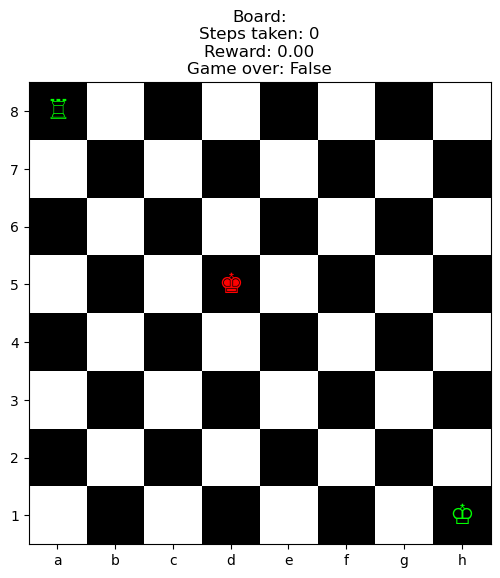

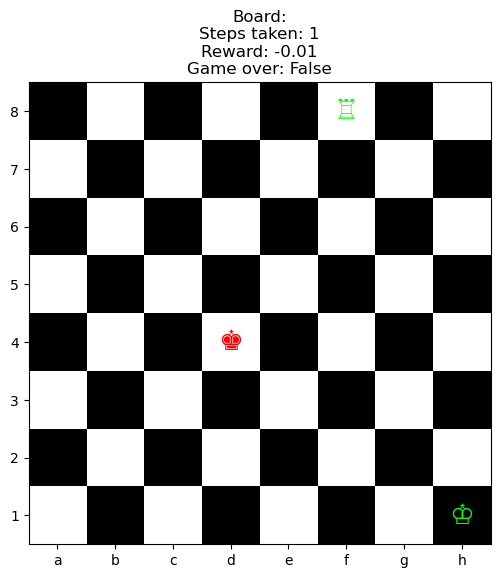

Move success: True Reward: -0.01


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random



class ChessEndgameEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        # Initial positions for simplicity; can be randomized later.
        self.white_king_pos = (7, 7)
        self.white_rook_pos = (0, 0)
        self.black_king_pos = (3, 3)
        self.done = False
        self.reward = 0 # Reward from last action
        self.max_steps = 100
        self.steps_taken = 0
        return self.get_state()

    def get_state(self):
        # State is a tuple of (WK_pos, WR_pos, BK_pos) to be hashable
        return (self.white_king_pos, self.white_rook_pos, self.black_king_pos)

    def is_within_board(self, pos):
        row, col = pos
        return 0 <= row < BOARD_SIZE and 0 <= col < BOARD_SIZE

    def are_kings_adjacent(self, king1_pos, king2_pos):
        return abs(king1_pos[0] - king2_pos[0]) <= 1 and abs(king1_pos[1] - king2_pos[1]) <= 1

    def _get_raw_king_moves(self, pos):
        # Returns all 8 possible moves for a king, without considering other pieces or board boundaries
        moves = []
        directions = [(-1, -1), (-1, 0), (-1, 1),
                      (0, -1),           (0, 1),
                      (1, -1),  (1, 0),  (1, 1)]
        for dr, dc in directions:
            new_pos = (pos[0] + dr, pos[1] + dc)
            if self.is_within_board(new_pos):
                moves.append(new_pos)
        return moves

    def get_rook_moves(self, pos):
        moves = []
        row, col = pos
        # Directions: Up, Down, Left, Right
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            r, c = row + dr, col + dc
            while self.is_within_board((r, c)):
                if (r, c) == self.white_king_pos:
                    break # Cannot move onto or past own king
                if (r, c) == self.black_king_pos:
                    moves.append((r, c)) # Can move to black king's square (capture)
                    break # But cannot move past black king
                moves.append((r, c))
                r, c = r + dr, c + dc
        return moves

    def is_square_attacked_by_white(self, pos):
        # Check attacked by white rook
        wr_r, wr_c = self.white_rook_pos
        # Check horizontal attack
        if pos[0] == wr_r:
            # Check if square 'pos' is on the path of the rook
            start_c, end_c = (min(pos[1], wr_c), max(pos[1], wr_c))
            path_clear = True
            for c in range(start_c + 1, end_c):
                if (wr_r, c) == self.white_king_pos or (wr_r, c) == self.black_king_pos:
                    path_clear = False
                    break
            if path_clear and pos != self.white_king_pos:
                return True
        # Check vertical attack
        if pos[1] == wr_c:
            start_r, end_r = (min(pos[0], wr_r), max(pos[0], wr_r))
            path_clear = True
            for r in range(start_r + 1, end_r):
                if (r, wr_c) == self.white_king_pos or (r, wr_c) == self.black_king_pos:
                    path_clear = False
                    break
            if path_clear and pos != self.white_king_pos:
                return True

        # Check attacked by white king (adjacent)
        if self.are_kings_adjacent(pos, self.white_king_pos) and pos != self.white_king_pos:
            return True
        return False

    def legal_black_moves(self):
        moves = []
        for new_bk_pos in self._get_raw_king_moves(self.black_king_pos):
            if new_bk_pos == self.white_king_pos or new_bk_pos == self.white_rook_pos:
                continue # Black king cannot move onto white pieces

            # Temporarily move black king to check if it's attacked
            original_bk_pos = self.black_king_pos
            self.black_king_pos = new_bk_pos

            # Check if the new position is attacked by white pieces
            if not self.is_square_attacked_by_white(new_bk_pos):
                # Also ensure black king doesn't move adjacent to white king
                if not self.are_kings_adjacent(new_bk_pos, self.white_king_pos):
                    moves.append(new_bk_pos)
            self.black_king_pos = original_bk_pos # Revert change
        return moves

    def black_move(self):
        moves = self.legal_black_moves()
        if not moves:
            return False  # No legal moves
        # For now, black randomly picks one legal move
        self.black_king_pos = random.choice(moves)
        return True

    def is_checkmate(self):
        # Black king must be in check
        if not self.is_square_attacked_by_white(self.black_king_pos):
            return False
        # And black king must have no legal moves
        if self.legal_black_moves():
            return False
        return True

    def is_stalemate(self):
        # Black king not in check
        if self.is_square_attacked_by_white(self.black_king_pos):
            return False
        # And black king has no legal moves
        if not self.legal_black_moves():
            return True
        return False

    def legal_white_moves(self):
        moves = []

        # White King moves
        for new_wk_pos in self._get_raw_king_moves(self.white_king_pos):
            if new_wk_pos == self.white_rook_pos: # Cannot move onto own rook
                continue

            # Temporarily update white king position to check legality
            original_wk_pos = self.white_king_pos
            self.white_king_pos = new_wk_pos

            # Check if white king moves into a square adjacent to black king
            if not self.are_kings_adjacent(self.white_king_pos, self.black_king_pos):
                moves.append(("WK", new_wk_pos))
            self.white_king_pos = original_wk_pos # Revert change

        # White Rook moves
        for new_wr_pos in self.get_rook_moves(self.white_rook_pos):
            # Cannot move onto white king (already handled by get_rook_moves `break` conditions)
            # It must also not expose the white king to check from the black king.
            original_wr_pos = self.white_rook_pos
            self.white_rook_pos = new_wr_pos

            # Check if white king is attacked by black king after rook move
            if not self.are_kings_adjacent(self.white_king_pos, self.black_king_pos):
                moves.append(("WR", new_wr_pos))
            self.white_rook_pos = original_wr_pos # Revert change
        return moves


    def move_white_piece(self, piece_type, new_pos):
        # Ensure the move is legal
        legal_moves = self.legal_white_moves()
        if (piece_type, new_pos) not in legal_moves:
            self.reward = -1.0 # Penalty for illegal move
            self.done = True
            return False, self.reward

        # Apply the move
        if piece_type == "WK":
            self.white_king_pos = new_pos
        elif piece_type == "WR":
            self.white_rook_pos = new_pos

        self.steps_taken += 1
        self.reward = -0.01 # Small penalty for each step

        # After white's move, check for terminal states
        if self.is_checkmate():
            self.reward = 1.0 # Reward for checkmate
            self.done = True
            return True, self.reward
        elif self.is_stalemate():
            self.reward = -0.5 # Penalty for stalemate (draw)
            self.done = True
            return True, self.reward
        elif self.steps_taken >= self.max_steps:
            self.reward = -0.5 # Penalty for exceeding max steps
            self.done = True
            return True, self.reward

        # If not terminal, Black makes a move
        black_moved = self.black_move()
        if not black_moved and not self.is_checkmate() and not self.is_stalemate():
            # If black has no legal moves and is not in check, it's a stalemate
            self.reward = -0.5
            self.done = True
            return True, self.reward

        # After black's move, re-check for terminal states (only checkmate/stalemate from white's perspective after black's move)
        if self.is_checkmate(): # This scenario implies white delivers checkmate and black has no moves.
            self.reward = 1.0
            self.done = True
        elif self.is_stalemate():
            self.reward = -0.5
            self.done = True
        elif self.steps_taken >= self.max_steps: # Should not happen here if already checked above for white's move
            self.reward = -0.5
            self.done = True

        return True, self.reward

    def render(self):
        board_size = BOARD_SIZE
        board_colors = np.zeros((board_size, board_size))

        # Create checkerboard pattern
        for row in range(board_size):
            for col in range(board_size):
                board_colors[row, col] = (row + col) % 2

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(board_colors, cmap='gray_r')

        def plot_piece(position, piece_label, color):
            row, col = position
            ax.text(col, 7 - row, piece_label, ha='center', va='center',
                    fontsize=20, fontweight='bold', color=color)

        plot_piece(self.white_king_pos, '♔', 'lime')
        plot_piece(self.white_rook_pos, '♖', 'lime')
        plot_piece(self.black_king_pos, '♚', 'red')

        ax.set_xticks(range(board_size))
        ax.set_yticks(range(board_size))
        ax.set_xticklabels(['a','b','c','d','e','f','g','h'])
        ax.set_yticklabels(range(1,9))

        ax.grid(False)
        plt.gca().invert_yaxis()
        plt.title(f"Board:\nSteps taken: {self.steps_taken}\nReward: {self.reward:.2f}\nGame over: {self.done}")
        plt.show()

env = ChessEndgameEnv()
state = env.reset()
env.render()

# Example move: move white rook from (0,0) to (0,5)
success, reward = env.move_white_piece("WR", (0, 5))
env.render()
print("Move success:", success, "Reward:", reward)


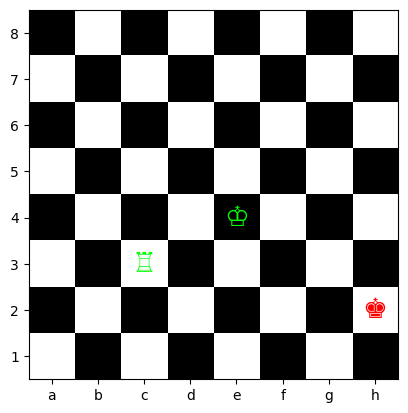

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_chessboard():
    board_size = 8
    board_colors = np.zeros((board_size, board_size))

    # Create checkerboard pattern
    for row in range(board_size):
        for col in range(board_size):
            board_colors[row, col] = (row + col) % 2

    # Randomize piece positions ensuring no overlap
    positions = set()
    def random_pos():
        while True:
            pos = (random.randint(0, board_size-1), random.randint(0, board_size-1))
            if pos not in positions:
                positions.add(pos)
                return pos

    white_king = random_pos()
    white_rook = random_pos()
    black_king = random_pos()

    fig, ax = plt.subplots()
    ax.imshow(board_colors, cmap='gray_r')

    # Coordinates for plotting (invert row for chessboard style)
    def plot_piece(position, piece_label, color):
        row, col = position
        ax.text(col, 7 - row, piece_label, ha='center', va='center',
                fontsize=20, fontweight='bold', color=color)

    plot_piece(white_king, '♔', 'lime')
    plot_piece(white_rook, '♖', 'lime')
    plot_piece(black_king, '♚', 'red')

    # Set ticks
    ax.set_xticks(range(board_size))
    ax.set_yticks(range(board_size))
    ax.set_xticklabels(['a','b','c','d','e','f','g','h'])
    ax.set_yticklabels(range(1,9))

    ax.grid(False)
    plt.gca().invert_yaxis()
    plt.show()

# Example usage with randomized positions each run
plot_chessboard()


### Step 3: Implement Q-Learning and SARSA for Chess Endgame

In [18]:
import random

class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.q_table = {}  # {(state, action): value}

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def best_action(self, state, legal_actions):
        q_values = [self.get_q(state, a) for a in legal_actions]
        max_q = max(q_values)
        best_actions = [a for a, q in zip(legal_actions, q_values) if q == max_q]
        return random.choice(best_actions)

    def choose_action(self, state, legal_actions):
        if random.random() < self.epsilon:
            return random.choice(legal_actions)
        else:
            return self.best_action(state, legal_actions)

    def update(self, state, action, reward, next_state, next_legal_actions):
        old_q = self.get_q(state, action)
        next_q = 0
        if next_legal_actions:
            next_q = max([self.get_q(next_state, a) for a in next_legal_actions])
        target = reward + self.gamma * next_q
        self.q_table[(state, action)] = old_q + self.lr * (target - old_q)

    def train_episode(self):
        state = self.env.reset()
        done = False
        total_reward = 0
        while not self.env.done:
            legal_actions = self.env.legal_white_moves()
            action = self.choose_action(state, legal_actions)
            success, reward = self.env.move_white_piece(*action)
            next_state = self.env.get_state()
            next_legal_actions = self.env.legal_white_moves() if not self.env.done else []
            self.update(state, action, reward, next_state, next_legal_actions)
            state = next_state
            total_reward += reward
        return total_reward


In [19]:
import random

class SARSAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.q_table = {}  # {(state, action): value}

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def best_action(self, state, legal_actions):
        q_values = [self.get_q(state, a) for a in legal_actions]
        max_q = max(q_values)
        best_actions = [a for a, q in zip(legal_actions, q_values) if q == max_q]
        return random.choice(best_actions)

    def choose_action(self, state, legal_actions):
        if random.random() < self.epsilon:
            return random.choice(legal_actions)
        else:
            return self.best_action(state, legal_actions)

    def update(self, state, action, reward, next_state, next_action):
        old_q = self.get_q(state, action)
        next_q = self.get_q(next_state, next_action) if next_action else 0
        target = reward + self.gamma * next_q
        self.q_table[(state, action)] = old_q + self.lr * (target - old_q)

    def train_episode(self):
        state = self.env.reset()
        done = False
        total_reward = 0
        legal_actions = self.env.legal_white_moves()
        action = self.choose_action(state, legal_actions)

        while not self.env.done:
            success, reward = self.env.move_white_piece(*action)
            next_state = self.env.get_state()
            next_legal_actions = self.env.legal_white_moves() if not self.env.done else []
            next_action = self.choose_action(next_state, next_legal_actions) if next_legal_actions else None
            self.update(state, action, reward, next_state, next_action)
            state = next_state
            action = next_action
            total_reward += reward
        return total_reward


Training Q-Learning Agent...
Episode 50/500 - Total reward: -1.49
Episode 100/500 - Total reward: -1.02
Episode 150/500 - Total reward: -1.49
Episode 200/500 - Total reward: -1.49
Episode 250/500 - Total reward: -1.49
Episode 300/500 - Total reward: -1.49
Episode 350/500 - Total reward: -0.56
Episode 400/500 - Total reward: -1.49
Episode 450/500 - Total reward: -1.49
Episode 500/500 - Total reward: -1.49

Training SARSA Agent...
Episode 50/500 - Total reward: -1.49
Episode 100/500 - Total reward: -1.49
Episode 150/500 - Total reward: -1.49
Episode 200/500 - Total reward: -1.49
Episode 250/500 - Total reward: -1.22
Episode 300/500 - Total reward: -1.49
Episode 350/500 - Total reward: -1.49
Episode 400/500 - Total reward: -1.49
Episode 450/500 - Total reward: -1.49
Episode 500/500 - Total reward: -1.49


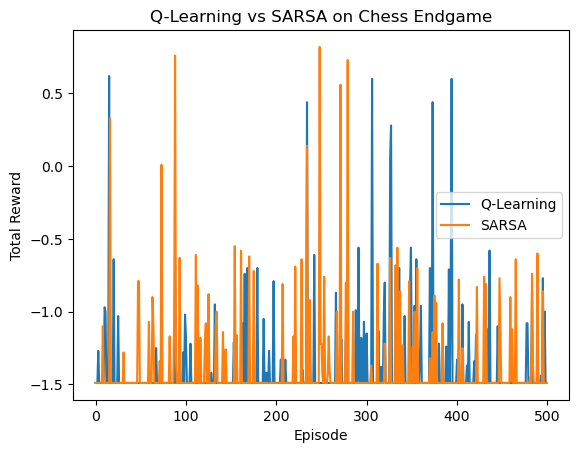

In [20]:
import matplotlib.pyplot as plt

def train_agent(agent, episodes=500):
    rewards = []
    for episode in range(episodes):
        total_reward = agent.train_episode()
        rewards.append(total_reward)
        if (episode+1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes} - Total reward: {total_reward:.2f}")
    return rewards

# Initialize environment
env = ChessEndgameEnv()

# Initialize agents
q_agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.95, epsilon=0.1)
sarsa_agent = SARSAgent(env, learning_rate=0.1, discount_factor=0.95, epsilon=0.1)

# Train Q-Learning agent
print("Training Q-Learning Agent...")
q_rewards = train_agent(q_agent)

# Train SARSA agent
print("\nTraining SARSA Agent...")
sarsa_rewards = train_agent(sarsa_agent)

# Plot and compare reward curves
plt.plot(q_rewards, label='Q-Learning')
plt.plot(sarsa_rewards, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning vs SARSA on Chess Endgame')
plt.legend()
plt.show()


### Step 4: Hyperparameter Tuning
To study the impact of hyperparameters, experiment by varying two parameters such as:

Learning rate (α): How fast the agent updates Q-values (try values like 0.1, 0.5, 0.9)

Exploration rate epsilon (ε): Probability of random action for exploration (try values like 0.1, 0.3, 0.5)

In [21]:
def tune_and_train(agent_class, env, learning_rates, epsilons, episodes=300):
    results = {}
    for lr in learning_rates:
        for eps in epsilons:
            print(f"\nTraining with lr={lr}, epsilon={eps}")
            agent = agent_class(env, learning_rate=lr, epsilon=eps)
            rewards = train_agent(agent, episodes)
            results[(lr, eps)] = rewards
    return results


### Step 5: Visualize Learned Policies

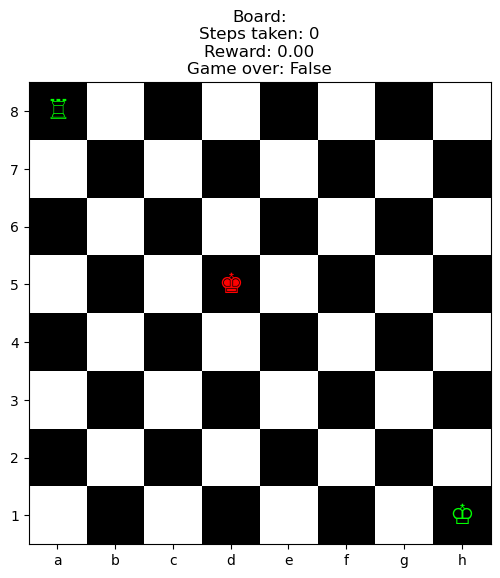

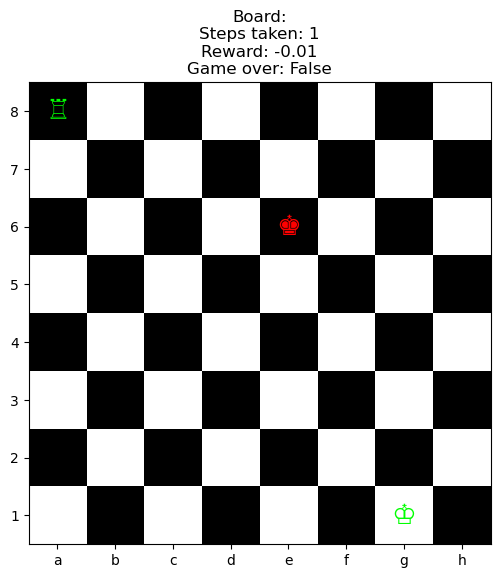

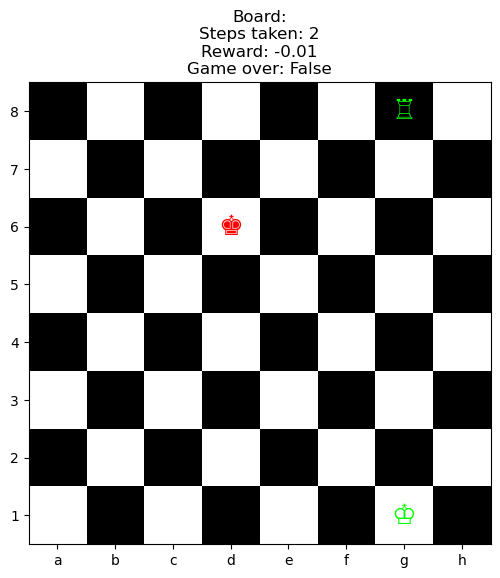

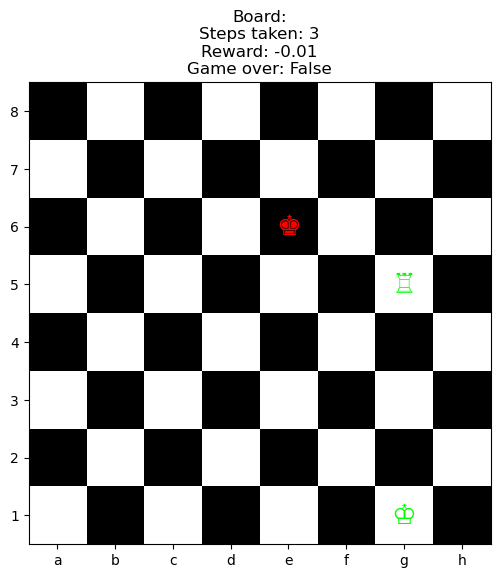

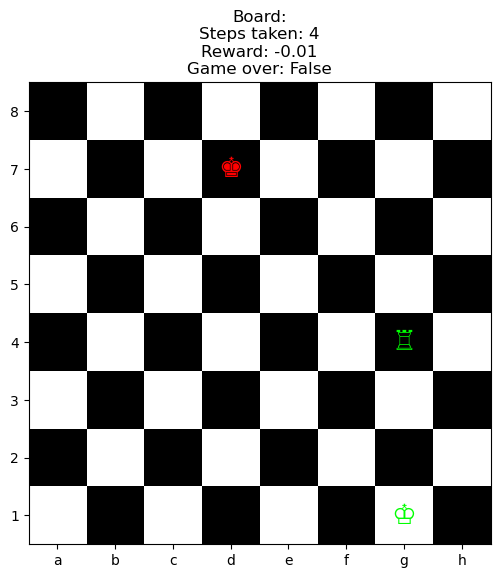

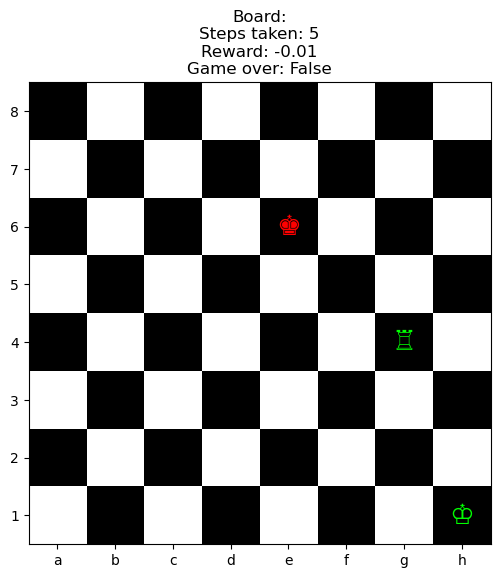

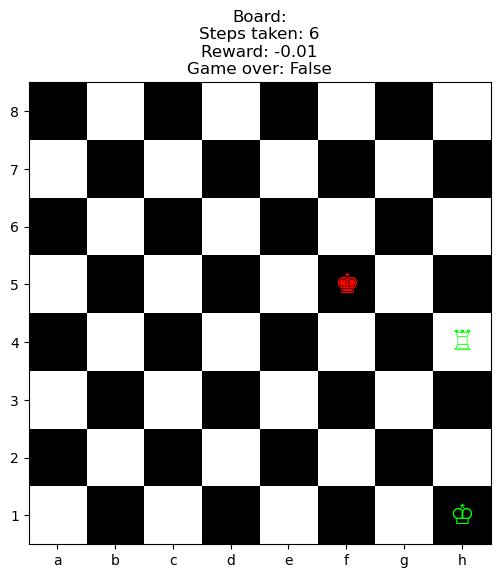

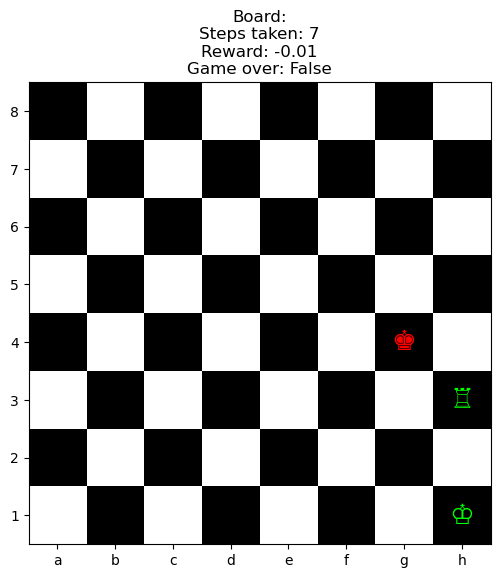

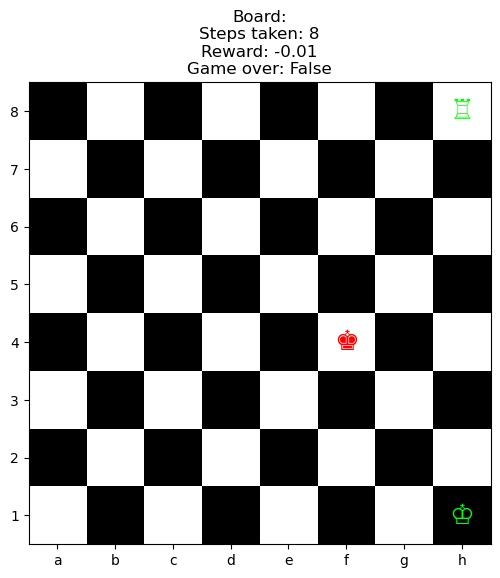

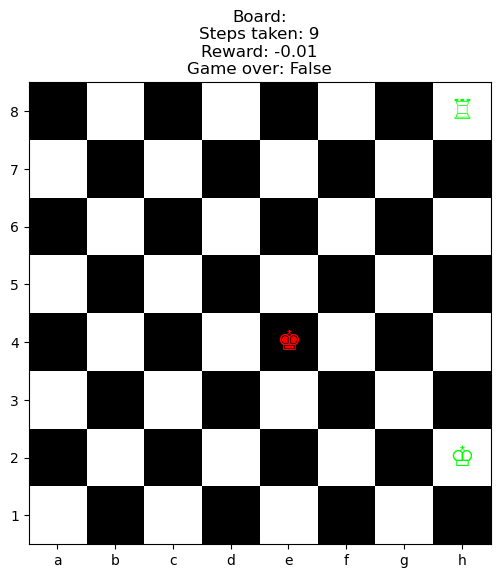

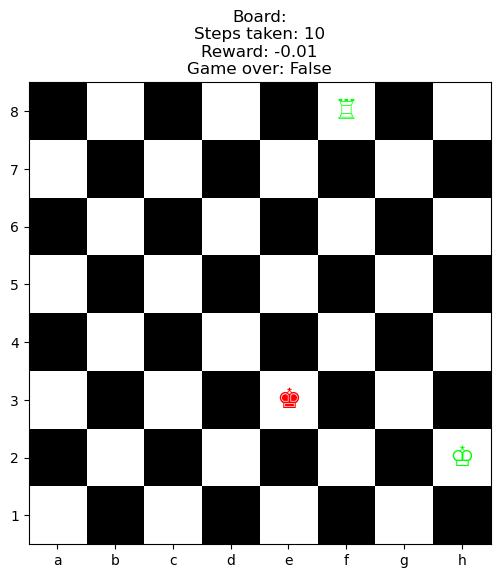

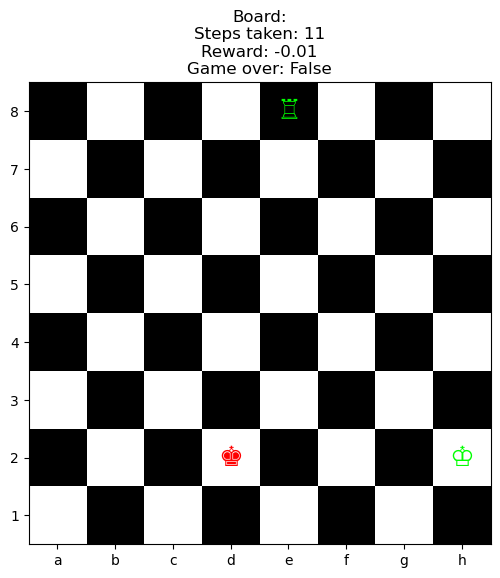

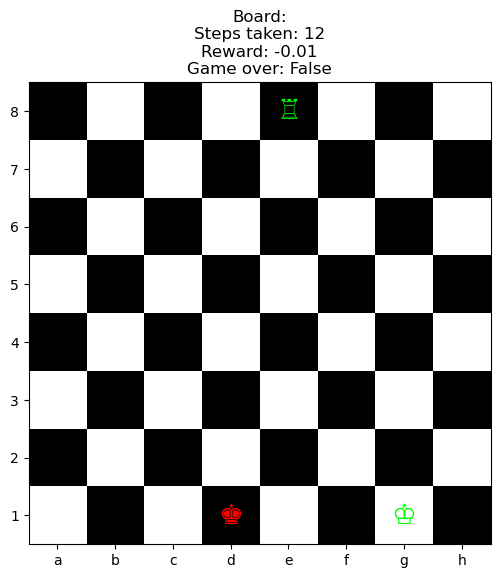

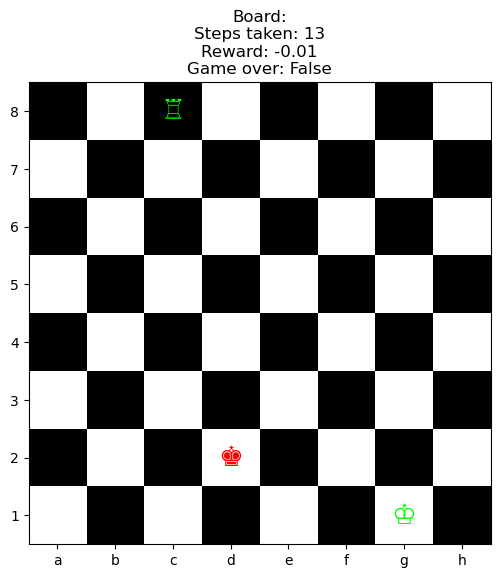

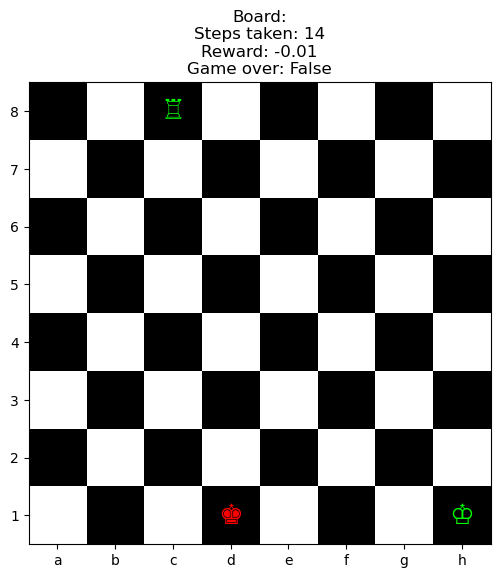

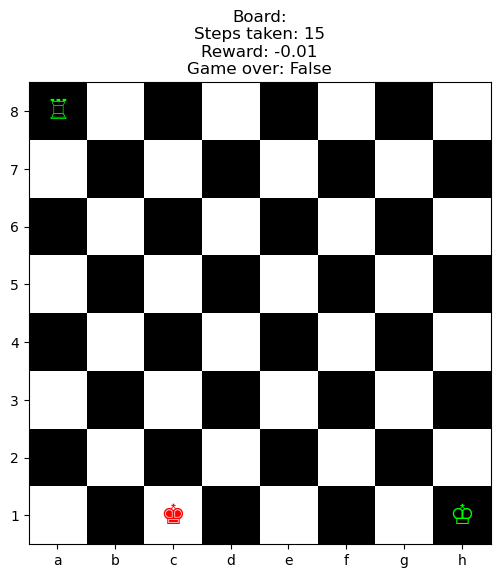

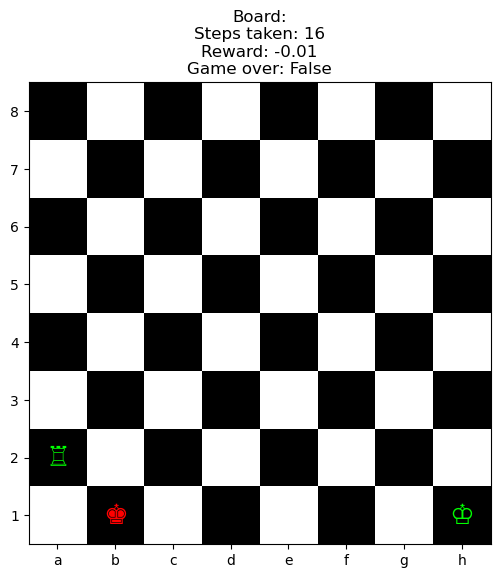

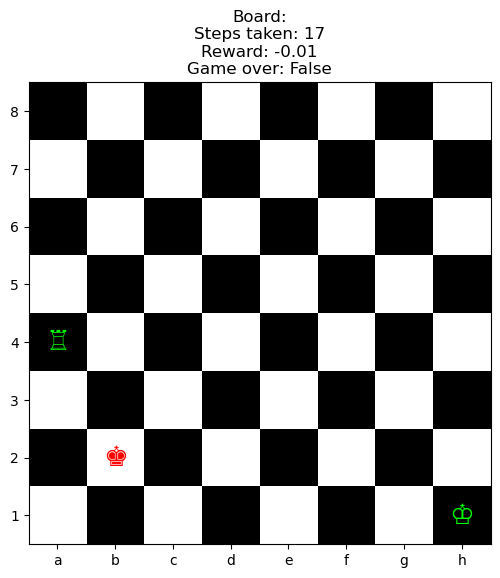

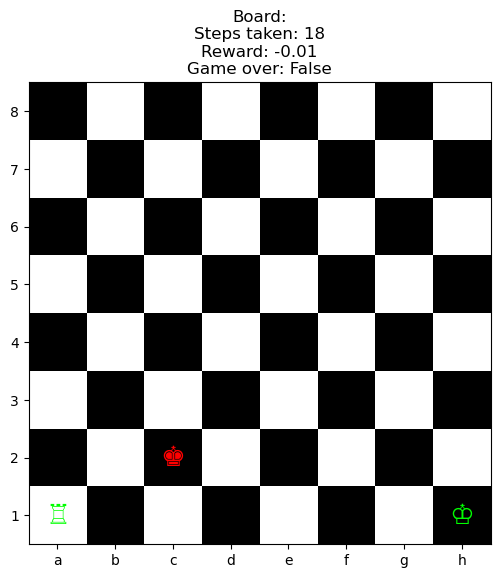

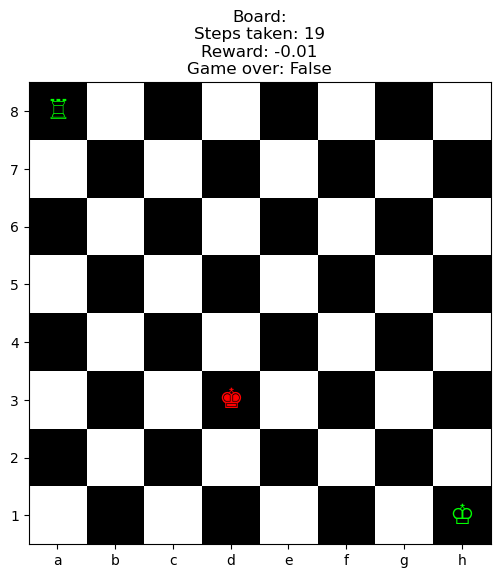

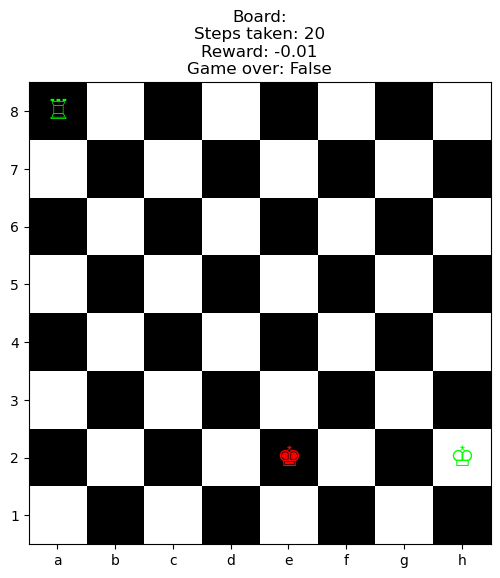

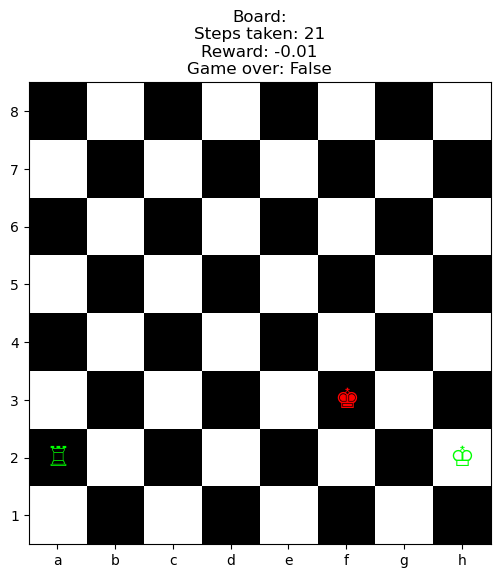

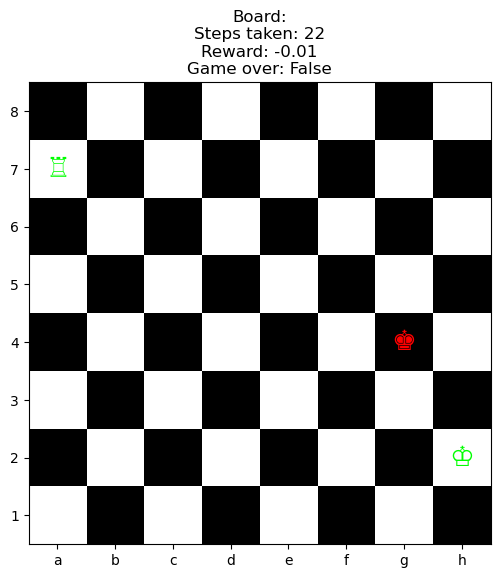

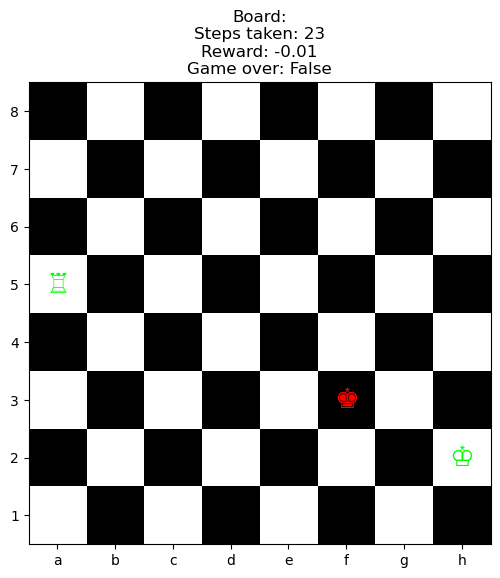

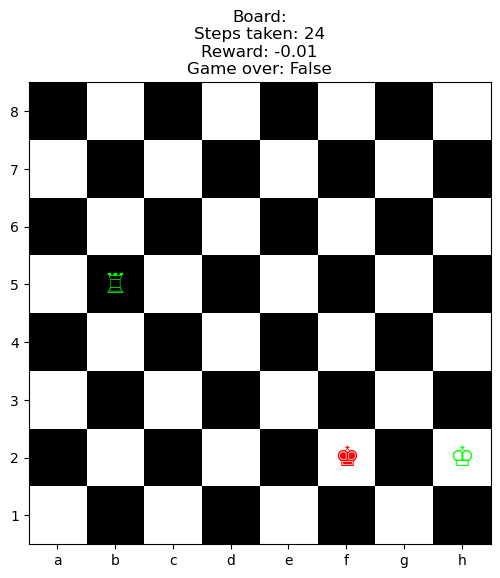

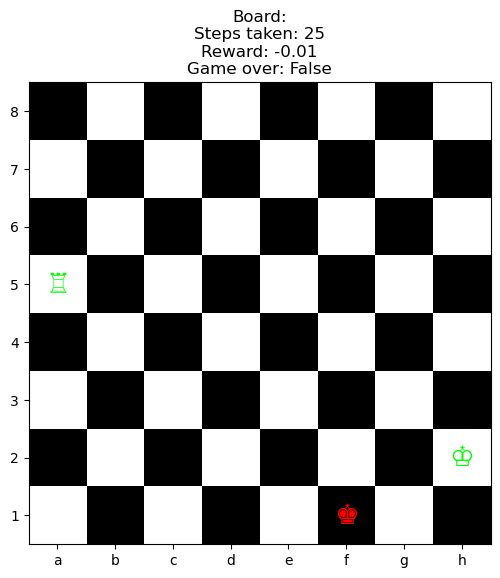

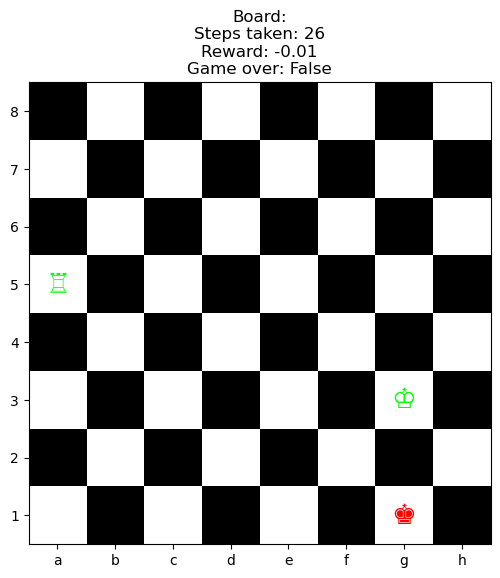

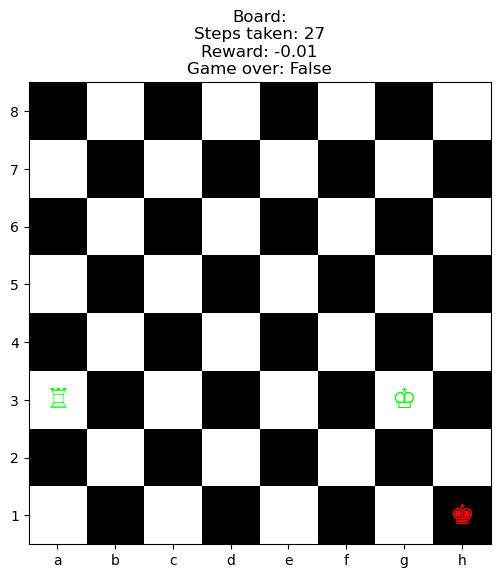

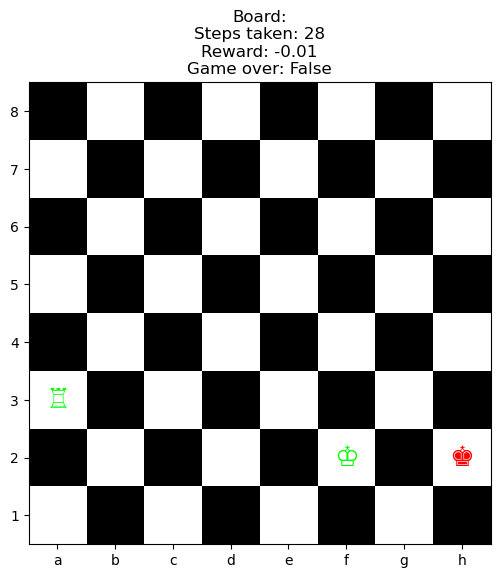

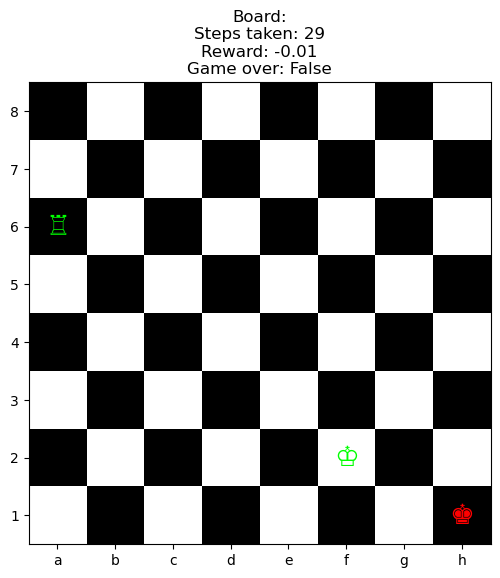

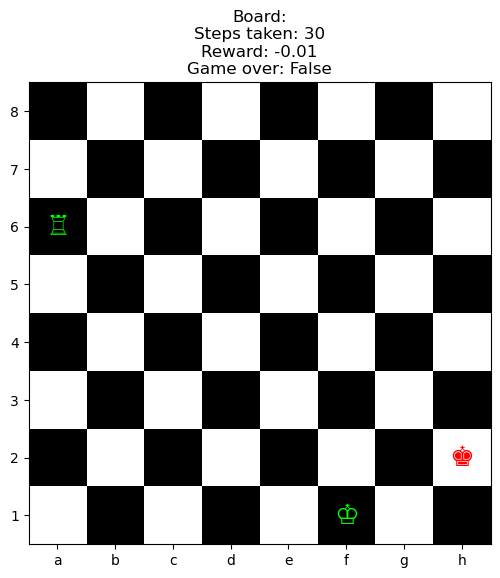

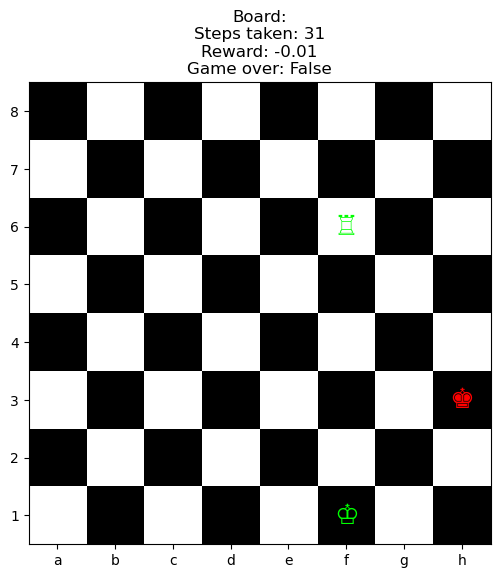

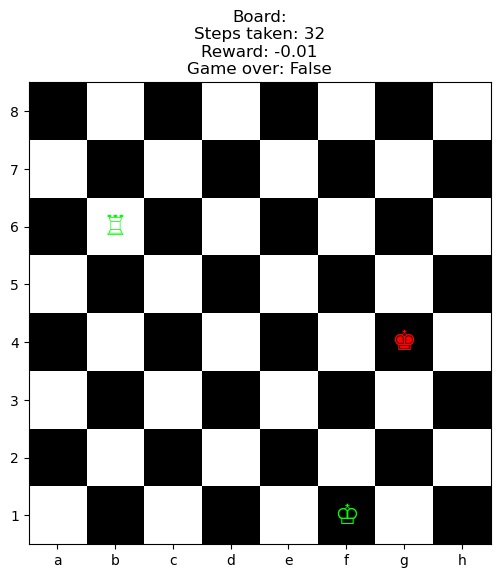

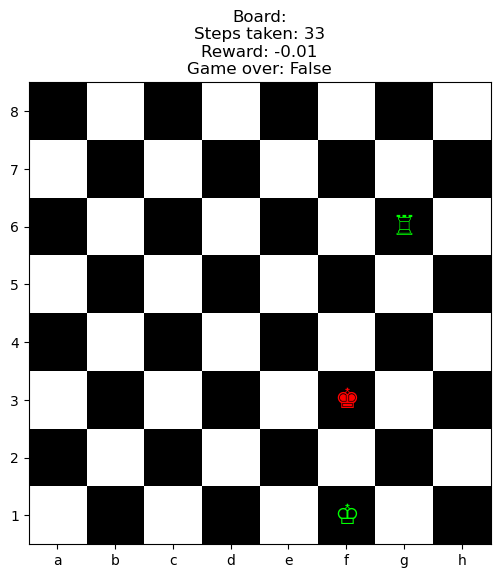

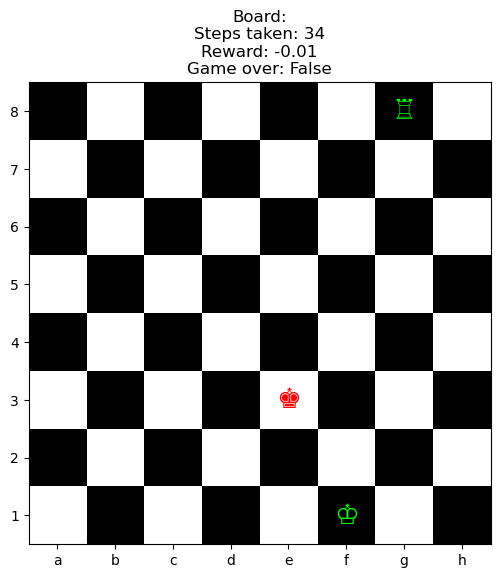

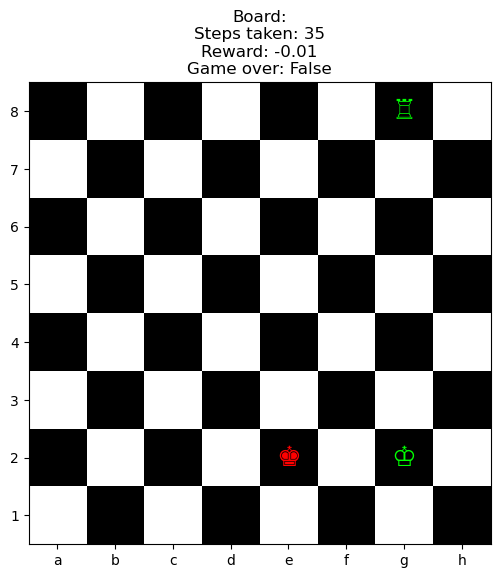

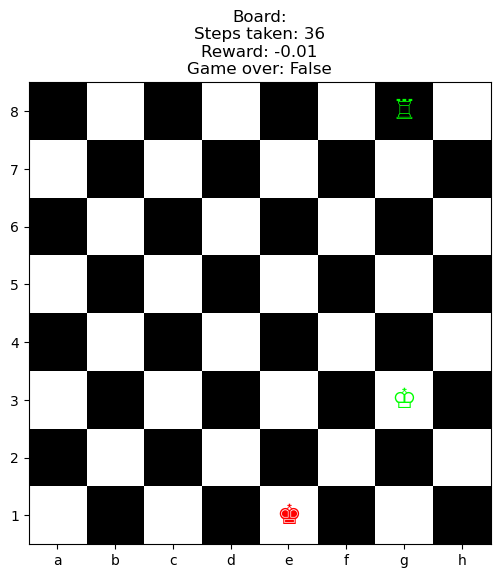

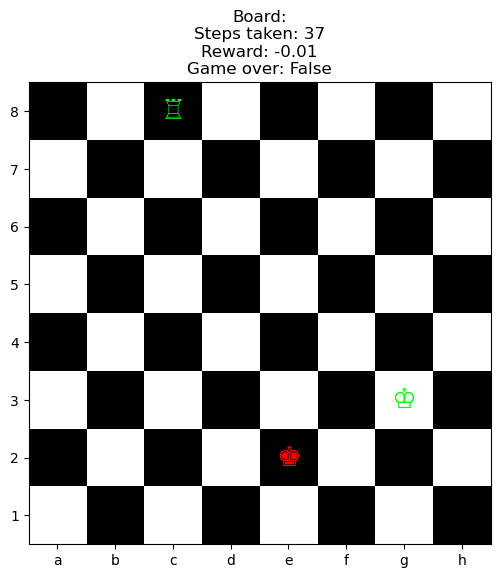

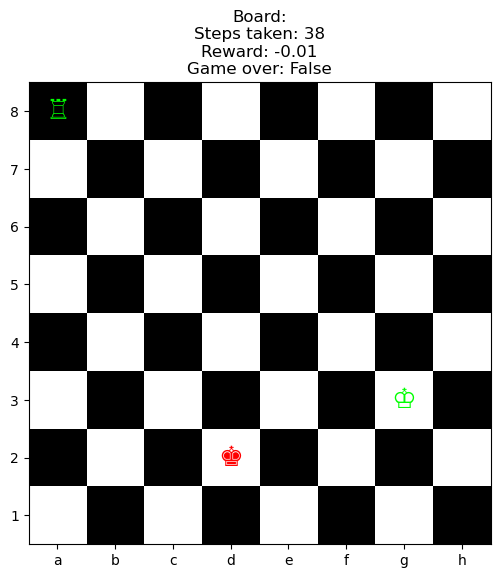

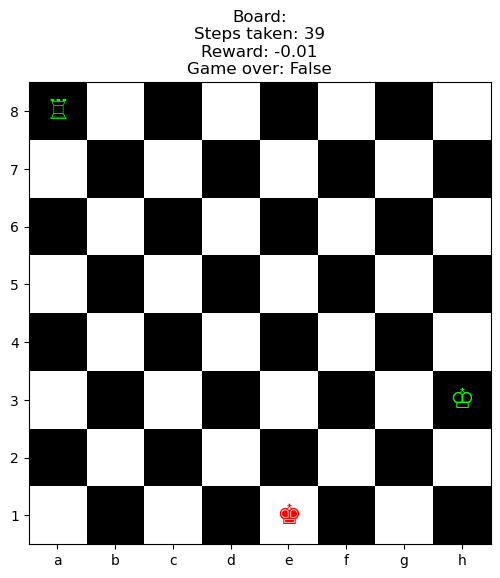

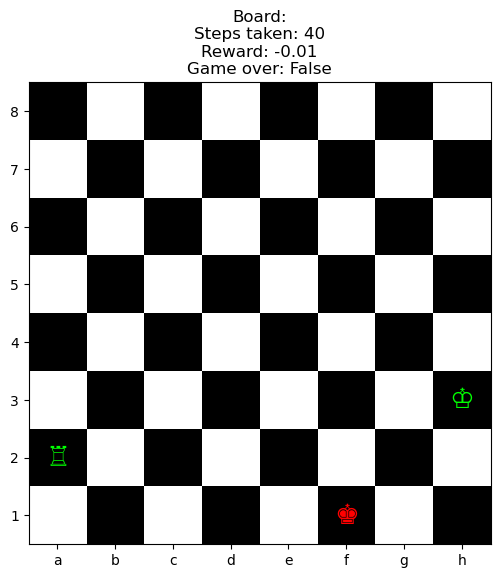

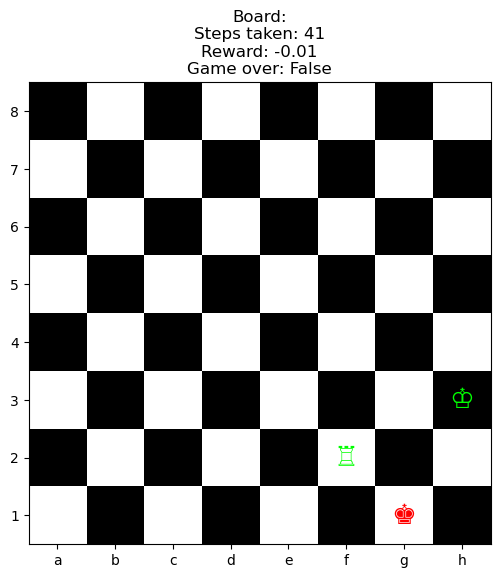

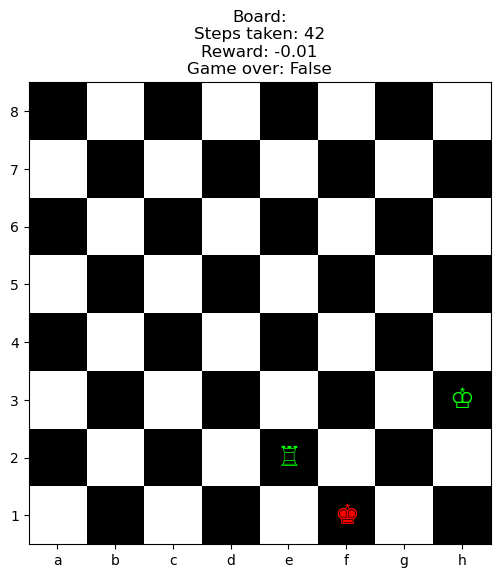

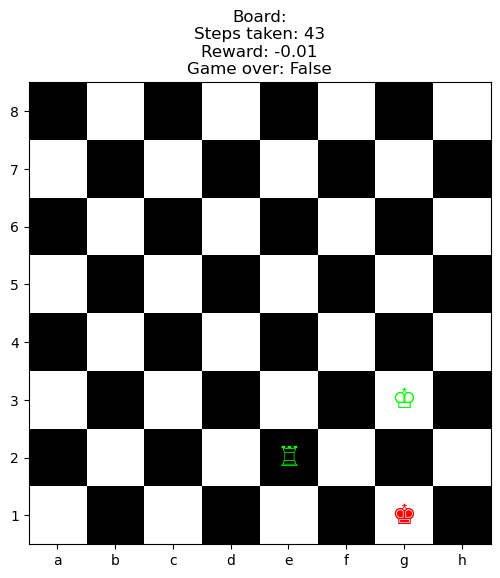

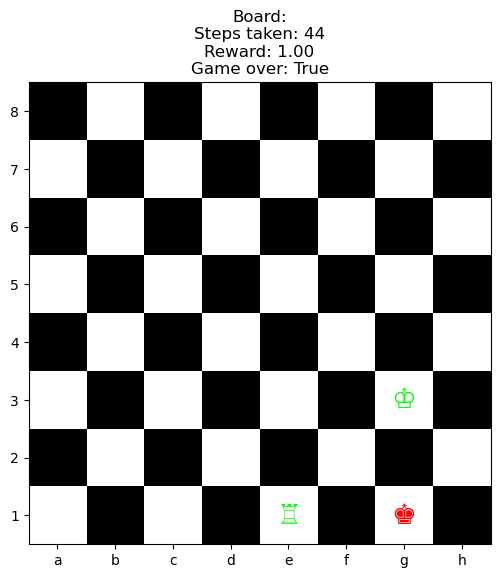

Episode finished with total reward: 0.5699999999999998


In [22]:
def evaluate_agent(agent, env, max_steps=100):
    # Set epsilon to 0 to fully exploit learned policy
    agent.epsilon = 0
    state = env.reset()
    env.render()
    total_reward = 0

    for step in range(max_steps):
        legal_actions = env.legal_white_moves()
        if not legal_actions or env.done:
            break
        action = agent.best_action(state, legal_actions)
        success, reward = env.move_white_piece(*action)
        env.render()
        state = env.get_state()
        total_reward += reward
        if env.done:
            break

    print(f"Episode finished with total reward: {total_reward}")

# Example usage
evaluate_agent(q_agent, env)
